# Introducton
This experiment is meant to replicate te results found in [this]() paper. 
Basically we want to notice the decay of error rate in terms of the number of saples from a bandlimited functon

In [1]:
# Create our imports
import importlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from samprecon.reconstructors.perfectupsampling import perfect_upsampling, sinc_interp
from samprecon.generators.bandlimited import BandlimitedSimple
from matplotlib.colors import ListedColormap

plt.style.use('rose-pine-dawn')
%load_ext autoreload
%autoreload 2

In [11]:
# Some Global Variables
training_modalities = np.logspace(2, 5, 4, base=2,dtype=int)
print(training_modalities)
epochs = 10000
baseline_samples = 16
lambda_l1 = 1
logging_interval = epochs//100
period = 1 ; # Thus frequency 1
signal_window = period*baseline_samples # Maybe change domain to -pi to pi

[ 4  8 16 32]


In [3]:
# Set Fixed Random Seed 
np.random.seed(0)

Some assumptions:
1. Number of requencies will be $17$
2. Assume period $T = 1$

 Size of upsampled signal: 32


/home/ottersome/.local/lib/python3.9/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home/ottersome/.local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/tmp/ipykernel_725634/3748346883.py:21: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axs[1].stem(np.linspace(-0.5,0.5,len(magnitude)), magnitude, label="Reconstructed Spectrum")


<StemContainer object of 3 artists>

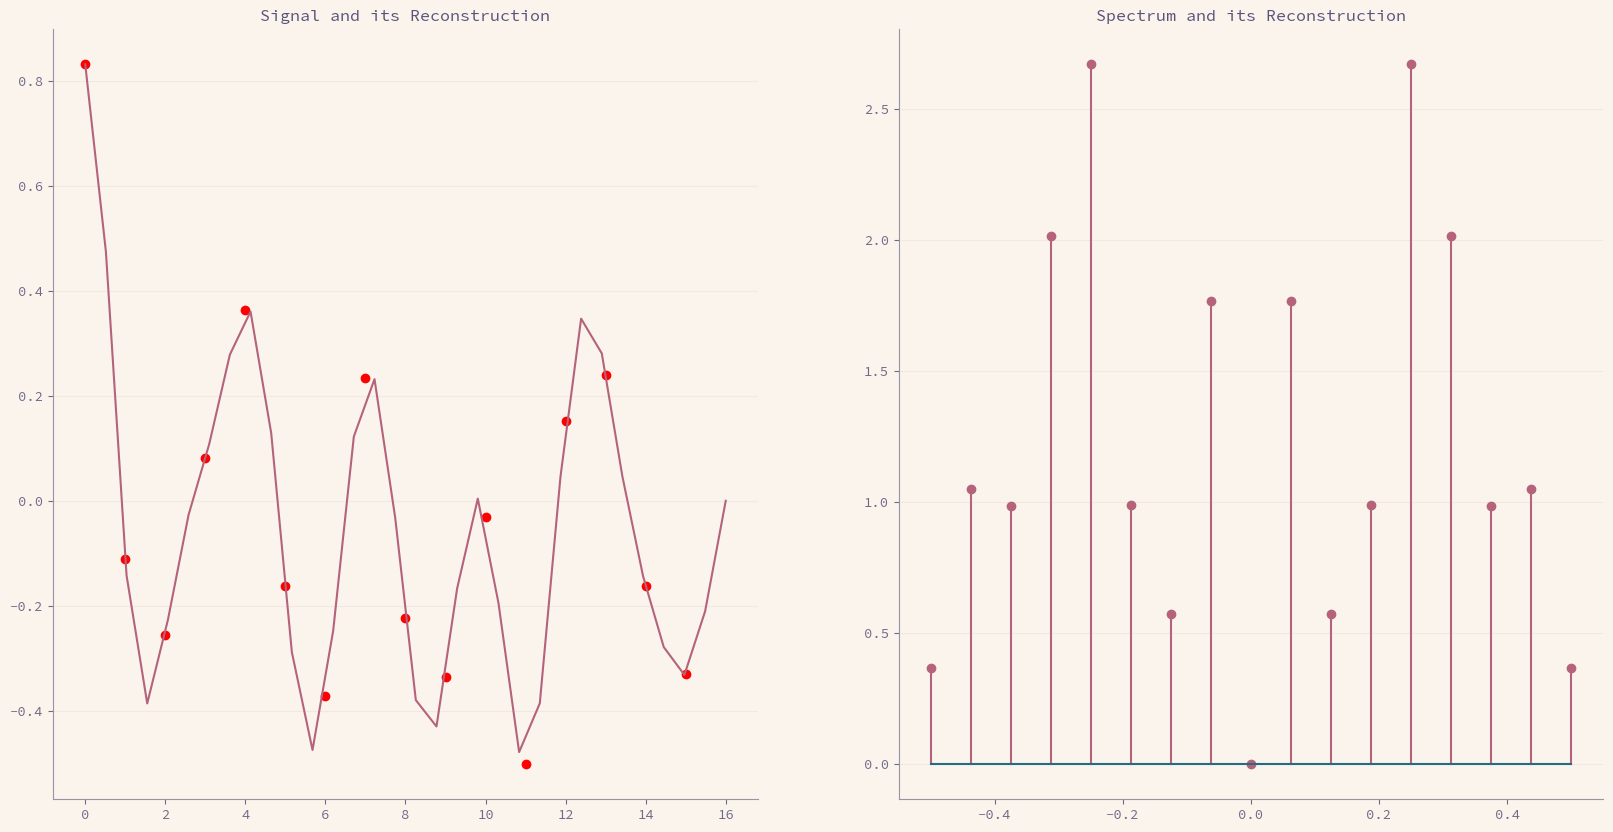

In [4]:
# Generate a single bandlimited signal
# with a sampling rate of 1000 Hz
signalGen = BandlimitedSimple(baseline_samples+1)
spectrum, signal  = signalGen.generate_signals(amount_of_signals=1)
signal = signal[0,:16]# I am joinst going to ingore the last sample to have nice multiples of 2
spectrum = spectrum[0]

# Upsample the Signal
up_t = np.linspace(0,len(signal), len(signal)*(training_modalities[-1]//baseline_samples))
upsampled_signal = sinc_interp(signal, 1, up_t)
print(f" Size of upsampled signal: {len(upsampled_signal)}")

# Plot the signal and its reconstruction in the same plot, also do one for its spectrum
fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].scatter(np.arange(len(signal)), signal, label="Samples",color='r')
axs[0].set_title(label="Signal and its Reconstruction")
axs[0].plot(up_t,upsampled_signal, label="Reconstructed Signal")

magnitude = np.real(np.abs(spectrum))
axs[1].set_title(label="Spectrum and its Reconstruction")
axs[1].stem(np.linspace(-0.5,0.5,len(magnitude)), magnitude, label="Reconstructed Spectrum")

In [14]:
# Try to learn it with asingle model
from samprecon.reconstructors.InfiniteWidthNet import InfiniteWidthNet 
import torch
from tqdm.notebook import tqdm

sampled_x = []
sampled_y = []
evals_y = []
# N defines the amount of samples to be used here
full_res_x = torch.tensor(np.linspace(0,signal_window,len(upsampled_signal)),dtype=torch.float).reshape(-1,1)
norms = []
for i,n in enumerate(training_modalities):

    model = InfiniteWidthNet()
    model = model.cuda()
    # Define loss function and optimizer
    # MSE Loss with weight regulation
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.1,weight_decay=0.01)

    jump = len(upsampled_signal)//n
    print(f"Using {n} samples, with a jump of {jump}")

    # Define input and target tensors
    # Unsqueeze x to had a dimension for the batch size
    x = torch.tensor(np.linspace(0,signal_window,n),dtype=torch.float).reshape(-1,1).cuda()
    y = torch.tensor(upsampled_signal[::jump],dtype=torch.float).reshape(-1,1).cuda()
    t = tqdm(range(epochs))

    # Train model
    for epoch in range(epochs):
        # Forward pass
        y_pred = model(x)

        # Compute loss
        l1_regularization = torch.norm(model.fc1.weight, 1)
        loss = criterion(y_pred, y) + lambda_l1 * l1_regularization

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        # Get Models Weights Spectral Norm

        inNorms = model.get_norms()
        if epochs % logging_interval == 0:
            norms.append(inNorms)

        #spectral_norm = model.get_spectral_norms()
        # Print loss
        t.set_description("Loss: {:.6f}, Spectral Norm {}".format(loss.item(), inNorms[0]))
        t.update(1)

    # Set model to eval mode
    model.eval()
    sampled_x.append(x.cpu().detach().numpy())
    sampled_y.append(y.cpu().detach().numpy())

    evals_y.append(model(full_res_x).detach().numpy())


Using 4 samples, with a jump of 8


  0%|          | 0/10000 [00:00<?, ?it/s]

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

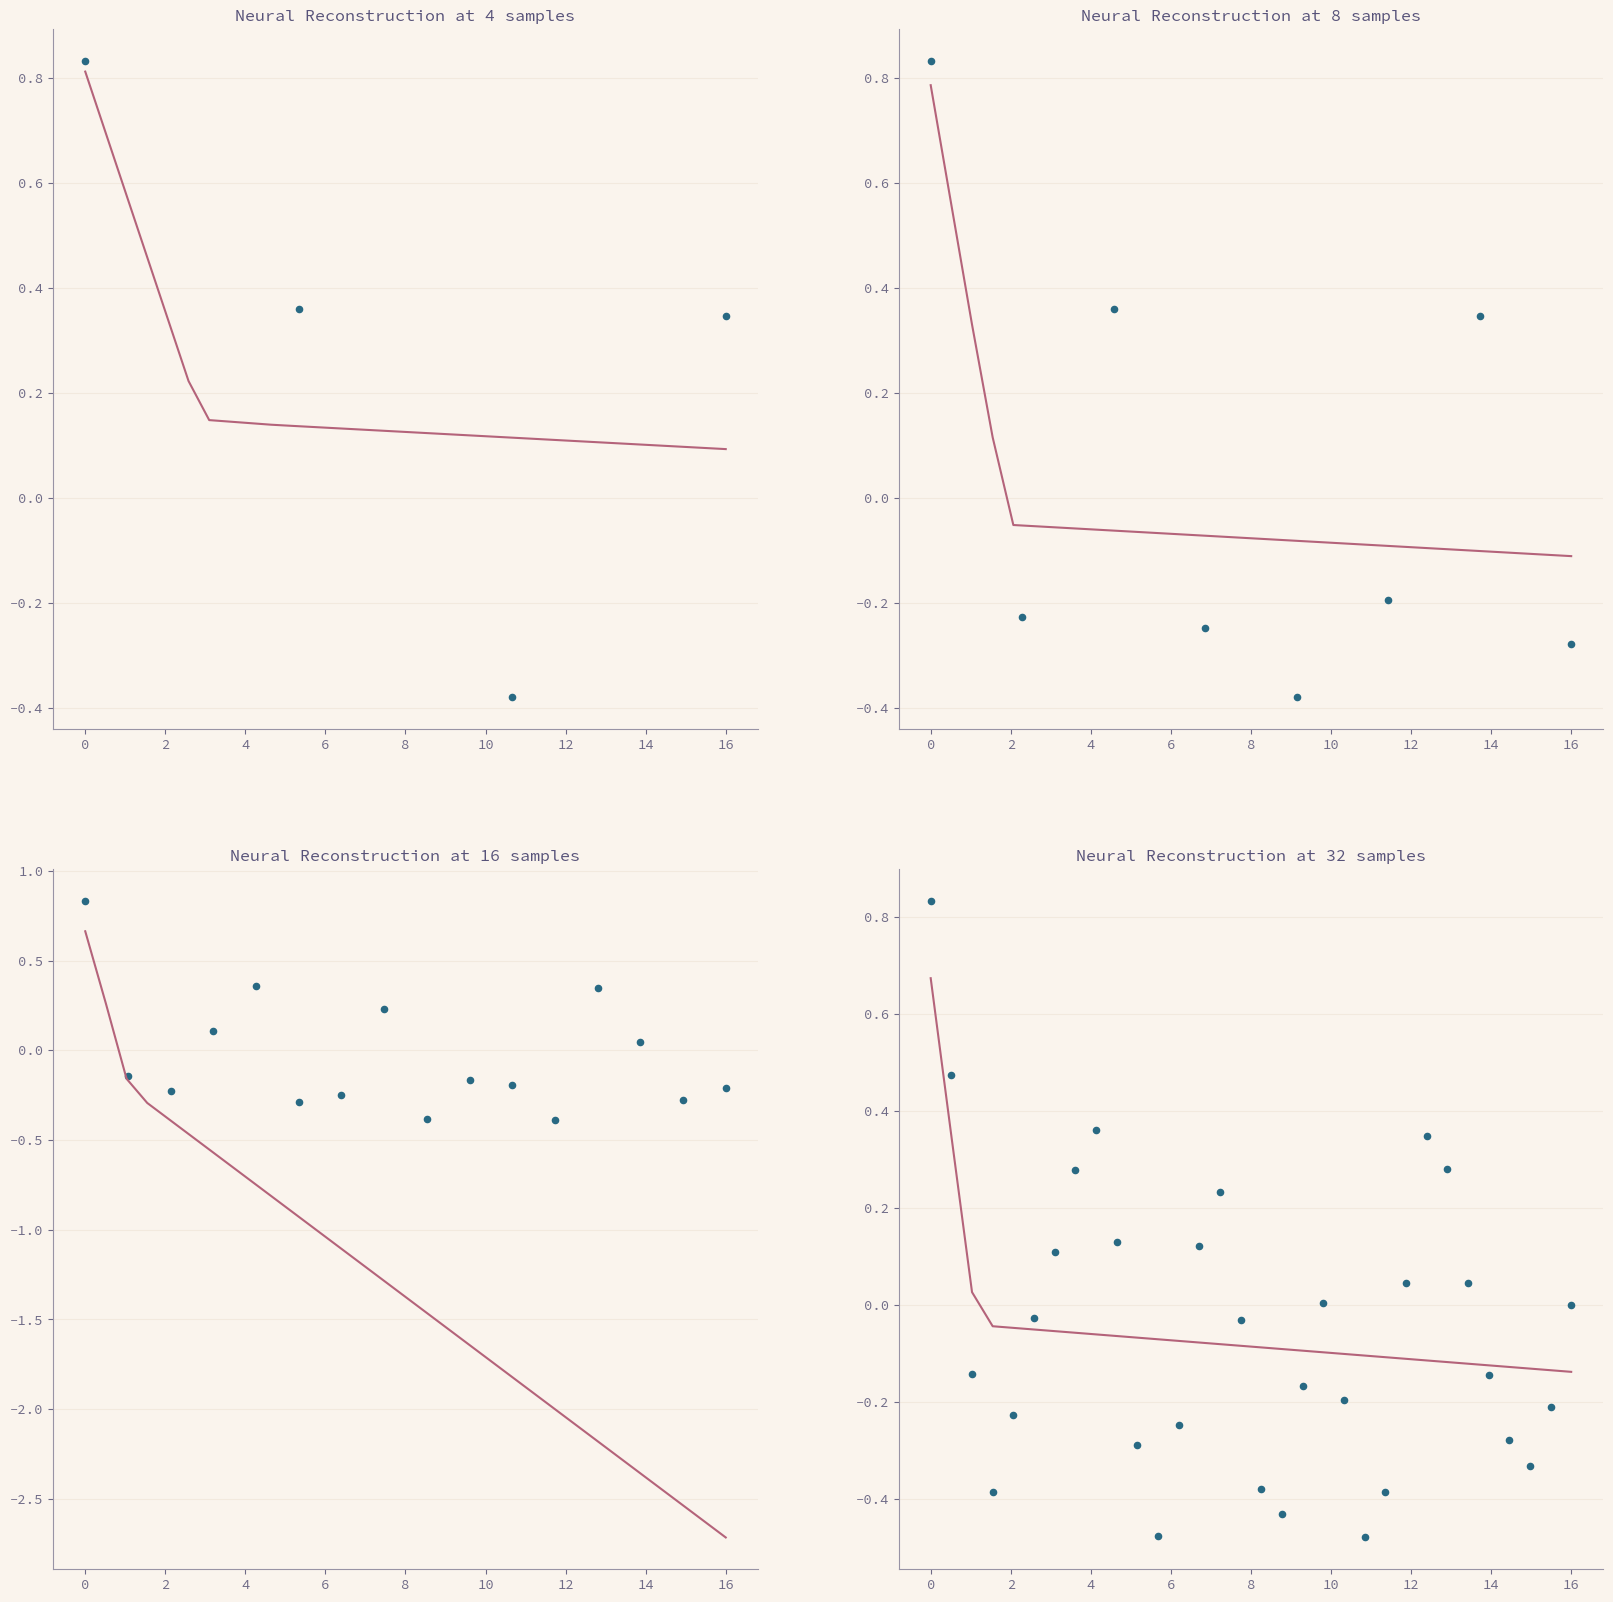

In [6]:

full_res_x = torch.tensor(np.linspace(0,signal_window,len(upsampled_signal)),dtype=torch.float).reshape(-1,1)
size = int(np.sqrt(len(training_modalities)))
fig,axs  = plt.subplots(size,size, figsize=(10*size,10*(size)))
for k in range(len(training_modalities)):
# Plot the signal and its reconstruction in the same plot, also do one for its spectrum
    i,j = (k//size,k%size )
    axs[i,j].scatter(sampled_x[k], sampled_y[k], label="Samples",color='#286983',s=20)
    axs[i,j].set_title("Neural Reconstruction at {} samples".format(training_modalities[k]))
    axs[i,j].plot(full_res_x,evals_y[k], label="Reconstructed Signal")

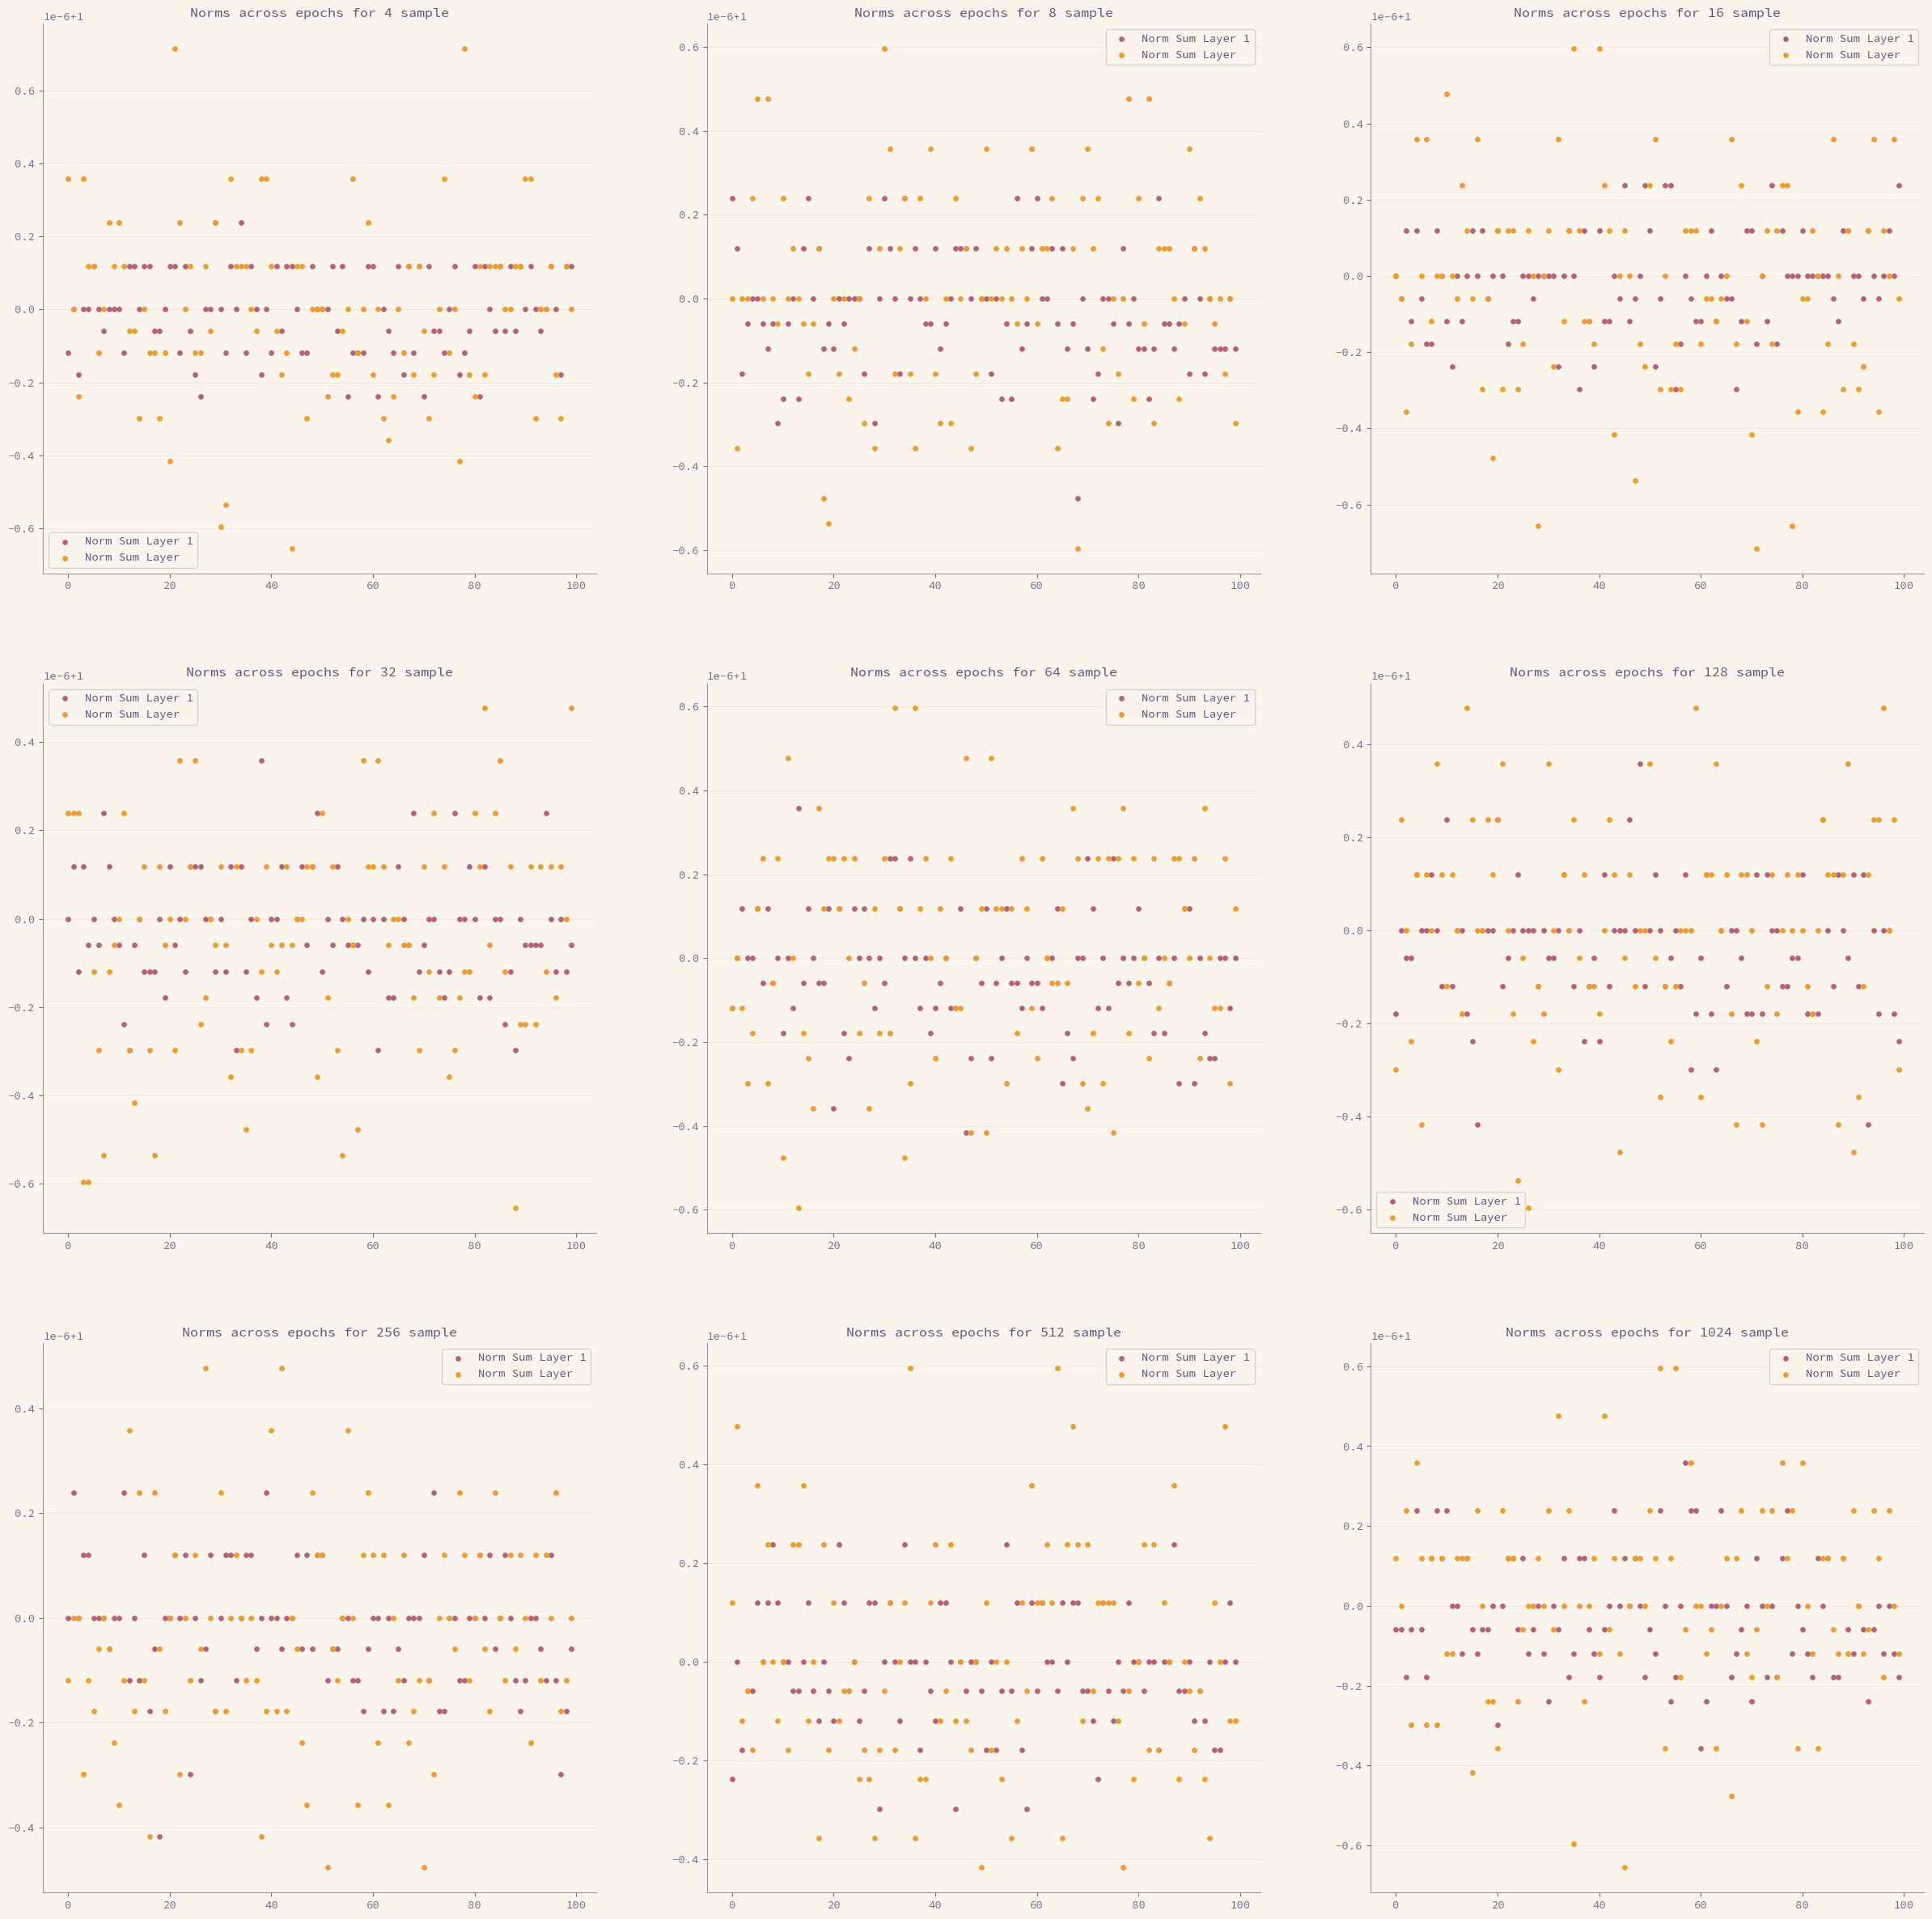

In [66]:
# Show norms

full_res_x = torch.tensor(np.linspace(0,signal_window,len(upsampled_signal)),dtype=torch.float).reshape(-1,1)
size = int(np.sqrt(len(training_modalities)))
fig,axs  = plt.subplots(size,size, figsize=(10*size,10*(size)))
for k in range(len(training_modalities)):
# Plot the signal and its reconstruction in the same plot, also do one for its spectrum
    i,j = (k//size,k%size )
    axs[i,j].scatter(range(epochs), norms0[k,:], label=f"Norm Sum Layer 1",s=15)#286983',s=5)
    axs[i,j].set_title("Norms across epochs for {} sample".format(training_modalities[k]))

    axs[i,j].scatter(range(epochs), norms1[k,:], label=f"Norm Sum Layer ",s=15)#286983',s=5)
    axs[i,j].set_title("Norms across epochs for {} sample".format(training_modalities[k]))
    # Show legend
    axs[i,j].legend()

In [ ]:
# Calculate the error
